In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor
from mapie.metrics import regression_coverage_score, regression_mean_width_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.linear_model import QuantileRegressor
from mapie.quantile_regression import MapieQuantileRegressor
from mapie._compatibility import np_quantile

np.random.seed(1)
rng = np.random.default_rng(1)
random_state = 42


## Needed for data and plotting


In [2]:
def get_1d_data(
    funct, mu: float, sigma: float, n_samples: int, noise: float
):
    X_train = np.random.uniform(0, 10.0, size=n_samples).astype(np.float32)
    X_test = np.random.uniform(0, 10.0, size=n_samples).astype(np.float32)

    # X_train = rng.normal(mu, sigma, n_samples)
    # X_test = np.arange(mu - 4 * sigma, mu + 4 * sigma, sigma / 20.0)

    y_train, y_test = funct(X_train), funct(X_test)

    n_train = X_train.shape[0]
    n_test = X_test.shape[0]

    y_train += rng.normal(0, noise, y_train.shape[0])
    y_test += rng.normal(0, noise, y_test.shape[0])

    X_train = np.reshape(X_train, (n_train, 1))
    X_test = np.reshape(X_test, (n_test, 1))
    return (
        X_train.reshape(-1, 1),
        y_train,
        X_test.reshape(-1, 1),
        y_test
    )



def plot_func(axs, x, y, pred=None, y_l=None, y_l_cqr=None, y_u=None, y_u_cqr=None, max_show=None, y_lim=None):
    if max_show == None:
        max_show = len(x)

    x_ = x[:max_show]
    y_ = y[:max_show]
    if y_u is not None:
        y_u_ = y_u[:max_show]
    if y_l is not None:
        y_l_ = y_l[:max_show]

    if y_u_cqr is not None:
        y_u_cqr_ = y_u_cqr[:max_show]
    if y_l_cqr is not None:
        y_l_cqr_ = y_l_cqr[:max_show]

    if pred is not None:
        pred_ = pred[:max_show]

    fig = plt.figure()
    inds = np.argsort(np.squeeze(x_))
    axs.plot(x_[inds, :], y_[inds], 'k.', alpha=.2, markersize=10,
             fillstyle='none', label=u'Observations')

    if (y_u_cqr_ is not None) and (y_l_cqr_ is not None):
        axs.fill(np.concatenate([x_[inds], x_[inds][::-1]]),
                 np.concatenate([y_u_cqr_[inds], y_l_cqr_[inds][::-1]]),
                 alpha=.3, color="red")

    if (y_u is not None) and (y_l is not None):
        axs.fill(np.concatenate([x_[inds], x_[inds][::-1]]),
                 np.concatenate([y_u_[inds], y_l_[inds][::-1]]),
                 alpha=.3, color="blue")

    if pred is not None:
        axs.plot(x_[inds, :], pred_[inds], 'k--', lw=2, alpha=0.9,
                 label=u'Predicted value')

    if y_lim == None:
        axs.set_ylim([np.min(y_test) * 1.3, np.max(y_test) * 1.3])
    else:
        axs.set_ylim([y_lim[0], y_lim[1]])
    axs.set_xlabel('$X$')
    axs.set_ylabel('$Y$')
    axs.legend(loc='upper right')
    plt.show()


def plot_results(axs, X_test, y_test, y_preds_low, y_preds_high, y_preds_low_cqr, y_preds_high_cqr, y_lim=None):
    inds = np.argsort(np.squeeze(X_test))
    axs.plot(X_test[inds], y_preds_low[inds], color="red")
    axs.plot(X_test[inds], y_preds_high[inds], color="red")

    axs.plot(X_test[inds], y_preds_low_cqr[inds], color="green")
    axs.plot(X_test[inds], y_preds_high_cqr[inds], color="green")
    axs.scatter(X_test[inds], y_test[inds], s=1, alpha=0.7)
    if y_lim == None:
        axs.set_ylim([np.min(y_test) * 1.3, np.max(y_test) * 1.3])
    else:
        axs.set_ylim([y_lim[0], y_lim[1]])
    plt.show()


## Construction of conformed prediction


In [3]:
def conformed_quantile_prediction(X_train, y_train,  X_test, y_test, alpha, regression_method="GradientBoosting", CV=0, symmetry=True):
    if regression_method == "GradientBoosting":
        mdl = GradientBoostingRegressor(
            loss="squared_error", random_state=random_state)
        mdl_low = GradientBoostingRegressor(
            loss="quantile", alpha=alpha/2, random_state=random_state)
        mdl_high = GradientBoostingRegressor(
            loss="quantile", alpha=1-(alpha/2), random_state=random_state)
    elif regression_method == "QuantileRegressor":
        mdl = QuantileRegressor(quantile=0.5)
        mdl_low = QuantileRegressor(quantile=alpha/2)
        mdl_high = QuantileRegressor(quantile=1-(alpha/2))
    # elif regression_method == "lightgbm":
    #     lgb_params = {
    #         'max_depth': 4,
    #         'boosting_type': 'gbdt'
    #     }
    #     mdl = LGBMRegressor(objective='regression', **lgb_params)
    #     mdl_low = LGBMRegressor(objective='quantile', metric="quantile",
    #                             alpha=alpha/2, **lgb_params)
    #     mdl_high = LGBMRegressor(objective='quantile', metric="quantile",
    #                              alpha=1-(alpha/2), **lgb_params)

    if CV > 1:
        kf = KFold(n_splits=CV, shuffle=True, random_state=random_state)
        pred_train_low, pred_train_high = [], []
        X_train_fit, X_train_calib, y_train_fit, y_train_calib = [], [], [], []
        for train_index, calib_index in kf.split(X_train.copy()):
            X_train_fit.extend(X_train[train_index])
            y_train_fit.extend(y_train[train_index])

            mdl_low_ = mdl_low
            mdl_low_.fit(X_train[train_index], y_train[train_index])
            y_train_preds_low = mdl_low_.predict(X_train[calib_index])
            pred_train_low.extend(y_train_preds_low)

            mdl_high_ = mdl_high
            mdl_high_.fit(X_train[train_index], y_train[train_index])
            y_train_preds_high = mdl_high_.predict(X_train[calib_index])
            pred_train_high.extend(y_train_preds_high)

            y_train_calib.extend(y_train[calib_index])

        pred_train_low = np.array(pred_train_low).flatten()
        pred_train_high = np.array(pred_train_high).flatten()
        y_train_calib = np.array(y_train_calib).flatten()

        mdl_ = mdl
        mdls = mdl_.fit(X_train_fit, y_train_fit)

        mdl_low_ = mdl_low
        mdls_low = mdl_low_.fit(X_train_fit, y_train_fit)

        mdl_high_ = mdl_high
        mdls_high = mdl_high_.fit(X_train_fit, y_train_fit)

    else:
        X_train_fit, X_train_calib, y_train_fit, y_train_calib = train_test_split(
            X_train, y_train, test_size=0.5, random_state=random_state)

        mdls = mdl.fit(X_train_fit, y_train_fit)

        mdls_low = mdl_low.fit(X_train_fit, y_train_fit)
        pred_train_low = mdls_low.predict(X_train_calib)

        mdls_high = mdl_high.fit(X_train_fit, y_train_fit)
        pred_train_high = mdls_high.predict(X_train_calib)

    if symmetry == True:
        scores = np.max([pred_train_low - y_train_calib,
                        y_train_calib - pred_train_high], axis=0)
        num_quant = (1-(alpha))*(1+(1/len(scores)))
        quantile_val = []
        quantile_val.append(np_quantile(scores, num_quant, method="higher"))
        quantile_val.append(quantile_val[0])
        print("num_quand: ", num_quant,
              "   quantile value:", quantile_val[0])
    else:
        scores_low = np.array(pred_train_low - y_train_calib)
        scores_high = np.array(y_train_calib - pred_train_high)
        quantile_val = []
        quantile_val.append(np_quantile(
            scores_low, (1-(alpha/2))*(1+(1/len(scores_low))), method="higher"))
        quantile_val.append(np_quantile(
            scores_high, (1-(alpha/2))*(1+(1/len(scores_high))), method="higher"))
        print((1-(alpha/2))*(1+(1/len(scores_high))))
        print("quantile value low: ",
              quantile_val[0], " then high :", quantile_val[1])

    print(quantile_val[0], quantile_val[1])
    y_preds = mdls.predict(X_test)
    y_preds_low = mdls_low.predict(X_test)
    y_preds_high = mdls_high.predict(X_test)

    y_preds_low_cqr = y_preds_low - quantile_val[0]
    y_preds_high_cqr = y_preds_high + quantile_val[1]
    return y_preds, y_preds_low, y_preds_low_cqr, y_preds_high, y_preds_high_cqr

def evaluate_all(X_train, y_train,  X_test, y_test, alpha, regression_method="GradientBoosting"):
    print("CV: FALSE, SYMMETRY: TRUE")
    y_preds, y_preds_low, y_preds_low_cqr, y_preds_high, y_preds_high_cqr = conformed_quantile_prediction(
        X_train, y_train,  X_test, y_test, alpha, regression_method=regression_method, CV=0, symmetry=True)
    evaluation_cqr(y_test, y_preds, y_preds_low,
                   y_preds_low_cqr, y_preds_high, y_preds_high_cqr)

    print()
    print()
    print("CV: TRUE, SYMMETRY: TRUE")
    y_preds, y_preds_low, y_preds_low_cqr, y_preds_high, y_preds_high_cqr = conformed_quantile_prediction(
        X_train, y_train,  X_test, y_test, alpha, regression_method=regression_method, CV=5, symmetry=True)
    evaluation_cqr(y_test, y_preds, y_preds_low,
                   y_preds_low_cqr, y_preds_high, y_preds_high_cqr)

    print()
    print()
    print("CV: FALSE, SYMMETRY: FALSE")
    y_preds, y_preds_low, y_preds_low_cqr, y_preds_high, y_preds_high_cqr = conformed_quantile_prediction(
        X_train, y_train,  X_test, y_test, alpha, regression_method=regression_method, CV=0, symmetry=False)
    evaluation_cqr(y_test, y_preds, y_preds_low,
                   y_preds_low_cqr, y_preds_high, y_preds_high_cqr)

    print()
    print()
    print("CV: TRUE, SYMMETRY: FALSE")
    y_preds, y_preds_low, y_preds_low_cqr, y_preds_high, y_preds_high_cqr = conformed_quantile_prediction(
        X_train, y_train,  X_test, y_test, alpha, regression_method=regression_method, CV=5, symmetry=False)
    evaluation_cqr(y_test, y_preds, y_preds_low,
                   y_preds_low_cqr, y_preds_high, y_preds_high_cqr)


def evaluation_cqr(y_test, y_preds, y_preds_low, y_preds_low_cqr, y_preds_high, y_preds_high_cqr):
    print("INITIAL coverage: ", round(regression_coverage_score(y_test, y_preds_low, y_preds_high),
          3), ", width: ", round(regression_mean_width_score(y_preds_low, y_preds_high), 3))
    print("CONFORMED coverage: ", round(regression_coverage_score(y_test, y_preds_low_cqr, y_preds_high_cqr),
          3), ", width ", round(regression_mean_width_score(y_preds_low_cqr, y_preds_high_cqr), 3))


In [4]:
# number of training examples
n_train = 3000
# number of test examples (to evaluate average coverage and length)
n_test = 1000


def f(x):
    ax = 0*x
    for i in range(len(x)):
        ax[i] = rng.poisson(np.sin(x[i])**2+0.1) + 0.03*x[i]*rng.random()
        ax[i] += 25*(rng.uniform(0, 1, 1) < 0.01)*rng.random()
    return ax.astype(np.float32)


# training features
X_train = rng.uniform(0, 5.0, size=n_train).astype(np.float32)
X_test = rng.uniform(0, 5.0, size=n_test).astype(np.float32)

# generate labels
y_train = f(X_train)
y_test = f(X_test)

# reshape the features
X_train = np.reshape(X_train, (n_train, 1))
X_test = np.reshape(X_test, (n_test, 1))


num_quand:  0.9006    quantile value: 0.0019086601279050246
0.0019086601279050246 0.0019086601279050246
0.905
q mapie  [0.9006]
quantile mapie  [0.00190866 0.00190866]
0.905


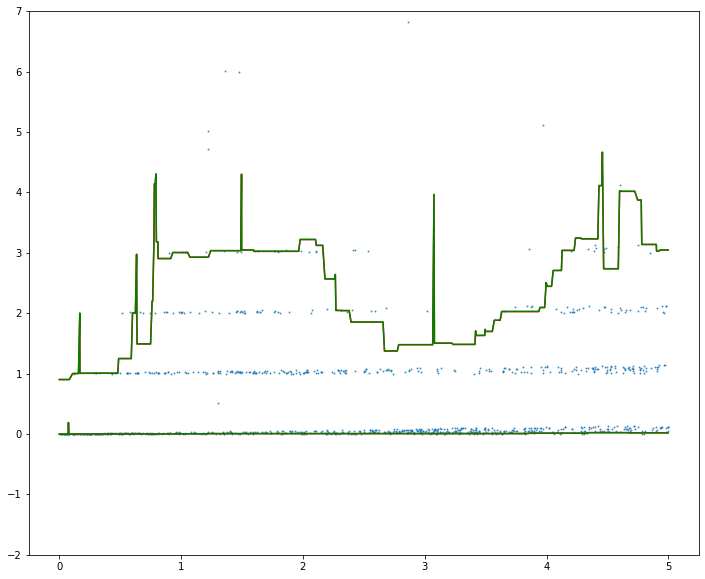

In [5]:
symmetry = True
alpha = 0.1


y_preds, y_preds_low, y_preds_low_cqr, y_preds_high, y_preds_high_cqr = conformed_quantile_prediction(
    X_train, y_train,  X_test, y_test, alpha, regression_method="GradientBoosting", CV=False, symmetry=symmetry)

print(regression_coverage_score(
    y_test, y_preds_low_cqr, y_preds_high_cqr
))

mapie_reg = MapieQuantileRegressor(
    GradientBoostingRegressor(loss="quantile"),
    cv="simple",
    alpha=alpha
)

mapie_reg.fit(X_train, y_train)
y_pred, y_pis = mapie_reg.predict(X_test, symmetry=symmetry)

print(regression_coverage_score(
    y_test, y_pis[:, 0, 0], y_pis[:, 1, 0]
))

fig, axs = plt.subplots(1, 1, figsize=(12, 10))
plot_results(axs, X_test, y_test, y_preds_low, y_preds_high,
             y_preds_low_cqr, y_preds_high_cqr, y_lim=[-2, 7])

num_quand:  0.900225    quantile value: 0.006946387378889973
0.006946387378889973 0.006946387378889973
0.889625
q mapie  [0.900225]
quantile mapie  [0.00694639 0.00694639]
0.889625


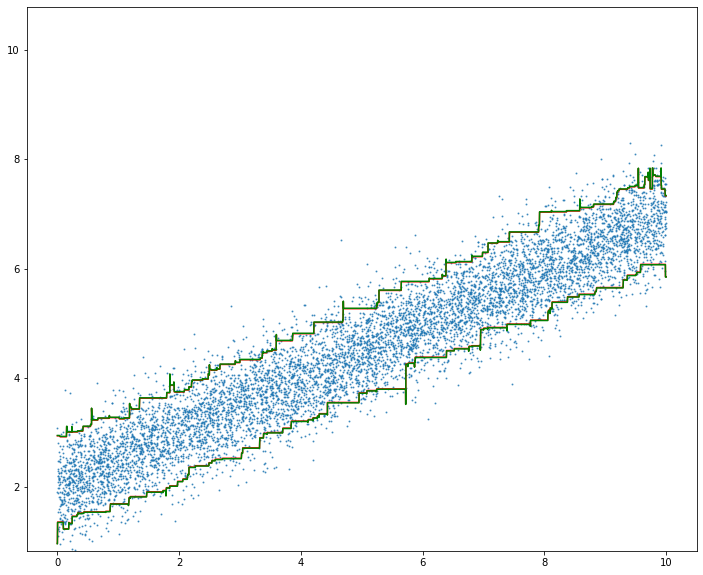

In [6]:
# Data generation
def linear_func(x):
    a, b = 0.5, 2
    return a * x + b


mu, sigma, n_samples, noise = 0, 2.5, 8000, 0.5
X_train, y_train, X_test, y_test = get_1d_data(
    linear_func, mu, sigma, n_samples, noise
)

symmetry = True
alpha = 0.1


y_preds, y_preds_low, y_preds_low_cqr, y_preds_high, y_preds_high_cqr = conformed_quantile_prediction(
    X_train, y_train,  X_test, y_test, alpha, regression_method="GradientBoosting", CV=False, symmetry=symmetry)

print(regression_coverage_score(
    y_test, y_preds_low_cqr, y_preds_high_cqr
))

mapie_reg = MapieQuantileRegressor(
    GradientBoostingRegressor(loss="quantile"),
    cv="simple",
    alpha=alpha
)

mapie_reg.fit(X_train, y_train)
y_pred, y_pis = mapie_reg.predict(X_test, symmetry=symmetry)

print(regression_coverage_score(
    y_test, y_pis[:, 0, 0], y_pis[:, 1, 0]
))

fig, axs = plt.subplots(1, 1, figsize=(12, 10))
plot_results(axs, X_test, y_test, y_preds_low, y_preds_high,
             y_preds_low_cqr, y_preds_high_cqr)


0.900225
quantile value low:  0.017574891202984944  then high : 0.046198648197875336
0.017574891202984944 0.046198648197875336
0.817
q mapie  [0.900225]
quantile mapie  [0.01757489 0.04619865]
0.817


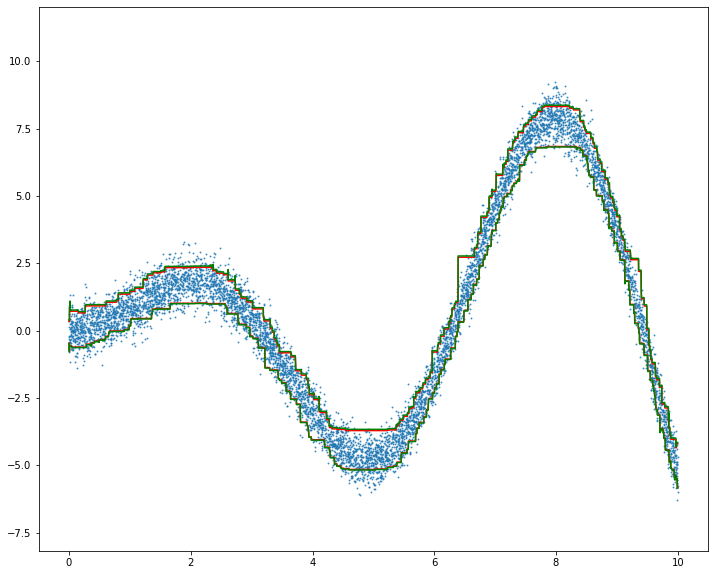

In [19]:
# Data generation
def x_sinx(x):
    """One-dimensional x*sin(x) function."""
    return x * np.sin(x)


mu, sigma, n_samples, noise = 0, 2.5, 8000, 0.5
X_train, y_train, X_test, y_test = get_1d_data(
    x_sinx, mu, sigma, n_samples, noise)

symmetry = False
alpha = 0.2


y_preds, y_preds_low, y_preds_low_cqr, y_preds_high, y_preds_high_cqr = conformed_quantile_prediction(
    X_train, y_train,  X_test, y_test, alpha, regression_method="GradientBoosting", CV=False, symmetry=symmetry)

print(regression_coverage_score(
    y_test, y_preds_low_cqr, y_preds_high_cqr
))

mapie_reg = MapieQuantileRegressor(
    GradientBoostingRegressor(loss="quantile"),
    cv="simple",
    alpha=alpha
)

mapie_reg.fit(X_train, y_train)
y_pred, y_pis = mapie_reg.predict(X_test, symmetry=symmetry)

print(regression_coverage_score(
    y_test, y_pis[:, 0, 0], y_pis[:, 1, 0]
))

fig, axs = plt.subplots(1, 1, figsize=(12, 10))
plot_results(axs, X_test, y_test, y_preds_low, y_preds_high,
             y_preds_low_cqr, y_preds_high_cqr)


In [9]:
from sklearn.model_selection import train_test_split

data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
X_boston = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
y_boston = raw_df.values[1::2, 2]

# Split the data into training and test sets.
X_train, X_test, y_train, y_test = train_test_split(
    X_boston, y_boston, test_size=0.2, random_state=42
)

symmetry = True
alpha = 0.1


y_preds, y_preds_low, y_preds_low_cqr, y_preds_high, y_preds_high_cqr = conformed_quantile_prediction(
    X_train, y_train,  X_test, y_test, alpha, regression_method="GradientBoosting", CV=False, symmetry=symmetry)

print(regression_coverage_score(
    y_test, y_preds_low_cqr, y_preds_high_cqr
))

mapie_reg = MapieQuantileRegressor(
    GradientBoostingRegressor(loss="quantile"),
    cv="simple",
    alpha=alpha
)

mapie_reg.fit(X_train, y_train)
y_pred, y_pis = mapie_reg.predict(X_test, symmetry=symmetry)

print(regression_coverage_score(
    y_test, y_pis[:, 0, 0], y_pis[:, 1, 0]
))

num_quand:  0.9044554455445545    quantile value: 2.6039540426629078
2.6039540426629078 2.6039540426629078
0.9411764705882353
q mapie  [0.90445545]
quantile mapie  [2.27970588 2.27970588]
0.9411764705882353


In [11]:
# Load input data and feature engineering
demand_df = pd.read_csv(
    "../../examples/data/demand_temperature.csv", parse_dates=True, index_col=0
)
demand_df["Date"] = pd.to_datetime(demand_df.index)
demand_df["Weekofyear"] = demand_df.Date.dt.isocalendar().week.astype("int64")
demand_df["Weekday"] = demand_df.Date.dt.isocalendar().day.astype("int64")
demand_df["Hour"] = demand_df.index.hour

# Train/validation/test split
num_test_steps = 24 * 7 * 2
demand_train = demand_df.iloc[:-num_test_steps, :].copy()
demand_test = demand_df.iloc[-num_test_steps:, :].copy()
X_train = demand_train.loc[:, ["Weekofyear", "Weekday",
                               "Hour", "Temperature"]].reset_index(drop=True).to_numpy()
y_train = demand_train["Demand"]
X_test = demand_test.loc[:, ["Weekofyear", "Weekday",
                             "Hour", "Temperature"]].reset_index(drop=True).to_numpy()
y_test = demand_test["Demand"]


num_quand:  0.9017857142857143    quantile value: 0.06418328290840813
0.06418328290840813 0.06418328290840813
0.8928571428571429
q mapie  [0.90178571]
quantile mapie  [0.06686527 0.06686527]
0.8928571428571429


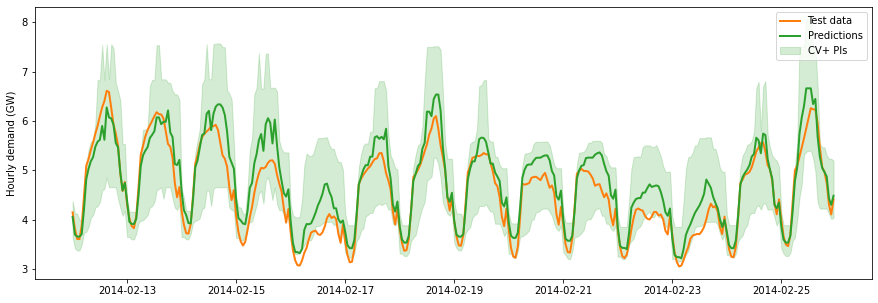

In [12]:
symmetry = True
alpha = 0.1


y_preds, y_preds_low, y_preds_low_cqr, y_preds_high, y_preds_high_cqr = conformed_quantile_prediction(
    X_train, y_train,  X_test, y_test, alpha, regression_method="GradientBoosting", CV=False, symmetry=symmetry)

print(regression_coverage_score(
    y_test, y_preds_low_cqr, y_preds_high_cqr
))

mapie_reg = MapieQuantileRegressor(
    GradientBoostingRegressor(loss="quantile"),
    cv="simple",
    alpha=alpha
)

mapie_reg.fit(X_train, y_train)
y_pred, y_pis = mapie_reg.predict(X_test, symmetry=symmetry)

print(regression_coverage_score(
    y_test, y_pis[:, 0, 0], y_pis[:, 1, 0]
))

# Plot estimated prediction intervals on test set
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(1, 1, 1)
ax.set_ylabel("Hourly demand (GW)")
ax.plot(y_test, lw=2, label="Test data", c="C1")
ax.plot(demand_test.index, y_preds, lw=2, c="C2", label="Predictions")
ax.fill_between(
    demand_test.index,
    y_preds_low_cqr,
    y_preds_high_cqr,
    color="C2",
    alpha=0.2,
    label="CV+ PIs",
)
ax.legend()
plt.show()


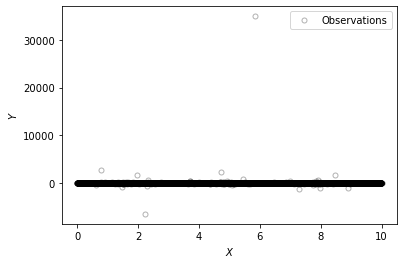

num_quand:  0.9008999999999999    quantile value: 0.9403891201369674
0.9403891201369674 0.9403891201369674
0.8942
q mapie  [0.9009]
quantile mapie  [0.94038912 0.94038912]
0.8942


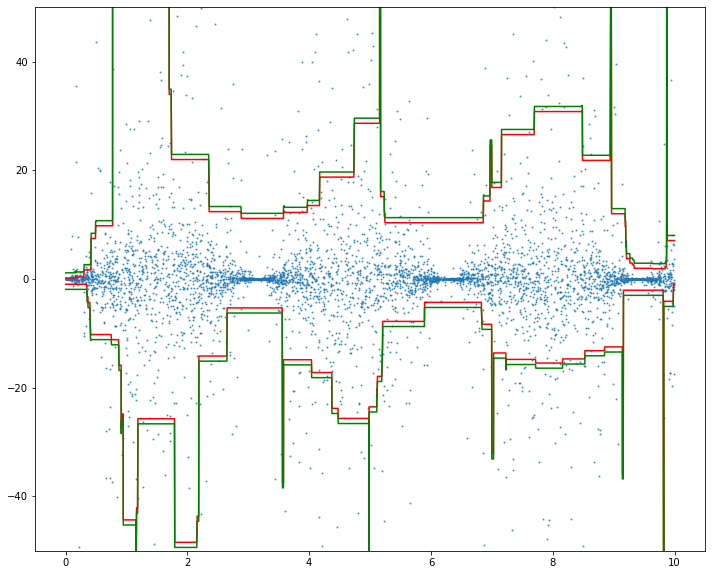

In [13]:
from scipy.stats import cauchy
# number of training examples
n_train = 2000
# number of test examples (to evaluate average coverage and length)
n_test = 5000

def f(x):
    ''' Construct data (1D example)
    '''
    ax = 0*x
    for i in range(len(x)):
        ax[i] = cauchy.rvs(loc=0, scale=6*(np.sin(x[i]))**2, size=1)
    x = ax
    return x.astype(np.float32)


# training features
X_train = rng.uniform(0, 10.0, size=n_train).astype(np.float32)

# test features
X_test = rng.uniform(0, 10.0, size=n_test).astype(np.float32)

# generate labels
y_train = f(X_train)
y_test = f(X_test)

# reshape the features
X_train = np.reshape(X_train, (n_train, 1))
X_test = np.reshape(X_test, (n_test, 1))

# display the test data in full range (including the outliers)
fig = plt.figure()
plt.plot(X_test, y_test, 'k.', alpha=0.3, markersize=10,
         fillstyle='none', label=u'Observations')
plt.legend()
plt.xlabel('$X$')
plt.ylabel('$Y$')
plt.show()

symmetry = True
alpha = 0.1


y_preds, y_preds_low, y_preds_low_cqr, y_preds_high, y_preds_high_cqr = conformed_quantile_prediction(
    X_train, y_train,  X_test, y_test, alpha, regression_method="GradientBoosting", CV=False, symmetry=symmetry)

print(regression_coverage_score(
    y_test, y_preds_low_cqr, y_preds_high_cqr
))

mapie_reg = MapieQuantileRegressor(
    GradientBoostingRegressor(loss="quantile"),
    cv="simple",
    alpha=alpha
)

mapie_reg.fit(X_train, y_train)
y_pred, y_pis = mapie_reg.predict(X_test, symmetry=symmetry)

print(regression_coverage_score(
    y_test, y_pis[:, 0, 0], y_pis[:, 1, 0]
))

fig, axs = plt.subplots(1, 1, figsize=(12, 10))
plot_results(axs, X_test, y_test, y_preds_low, y_preds_high,
             y_preds_low_cqr, y_preds_high_cqr, y_lim=[-50, 50])


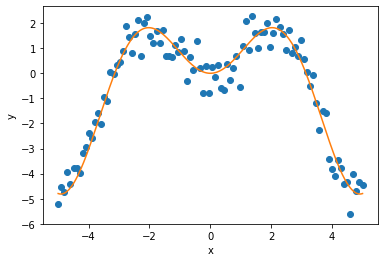

In [14]:
import matplotlib.pyplot as plt
import numpy as np


def x_sinx(x):
    """One-dimensional x*sin(x) function."""
    return x*np.sin(x)


def get_1d_data_with_constant_noise(funct, min_x, max_x, n_samples, noise):
    """
    Generate 1D noisy data uniformely from the given function
    and standard deviation for the noise.
    """
    np.random.seed(59)
    X_train = np.linspace(min_x, max_x, n_samples)
    np.random.shuffle(X_train)
    X_test = np.linspace(min_x, max_x, n_samples*5)
    y_train, y_mesh, y_test = funct(X_train), funct(X_test), funct(X_test)
    y_train += np.random.normal(0, noise, y_train.shape[0])
    y_test += np.random.normal(0, noise, y_test.shape[0])
    return X_train.reshape(-1, 1), y_train, X_test.reshape(-1, 1), y_test, y_mesh


min_x, max_x, n_samples, noise = -5, 5, 100, 0.5
X_train, y_train, X_test, y_test, y_mesh = get_1d_data_with_constant_noise(
    x_sinx, min_x, max_x, n_samples, noise
)

plt.xlabel("x")
plt.ylabel("y")
plt.scatter(X_train, y_train, color="C0")
_ = plt.plot(X_test, y_mesh, color="C1")


num_quand:  0.918    quantile value: 1.096370626853518
1.096370626853518 1.096370626853518
0.966
q mapie  [0.918]
quantile mapie  [1.09637063 1.09637063]
0.966


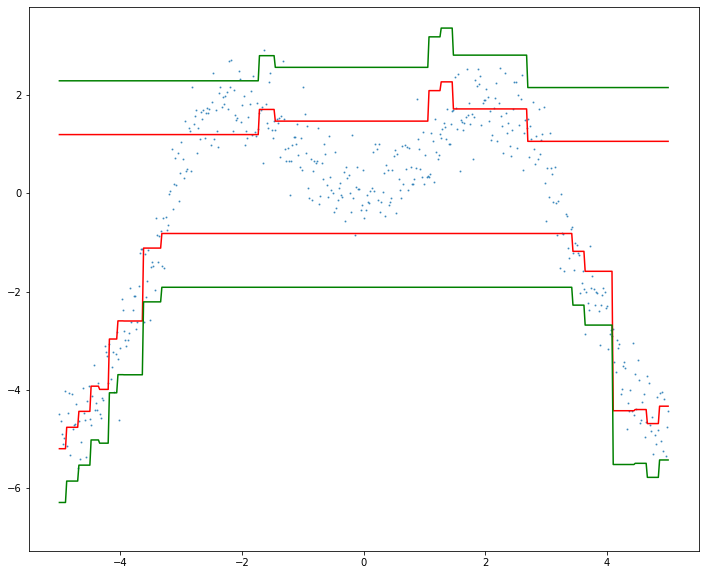

In [15]:
symmetry = True
alpha = 0.1


y_preds, y_preds_low, y_preds_low_cqr, y_preds_high, y_preds_high_cqr = conformed_quantile_prediction(
    X_train, y_train,  X_test, y_test, alpha, regression_method="GradientBoosting", CV=False, symmetry=symmetry)

print(regression_coverage_score(
    y_test, y_preds_low_cqr, y_preds_high_cqr
))

mapie_reg = MapieQuantileRegressor(
    GradientBoostingRegressor(loss="quantile"),
    cv="simple",
    alpha=alpha
)

mapie_reg.fit(X_train, y_train)
y_pred, y_pis = mapie_reg.predict(X_test, symmetry=symmetry)

print(regression_coverage_score(
    y_test, y_pis[:, 0, 0], y_pis[:, 1, 0]
))

fig, axs = plt.subplots(1, 1, figsize=(12, 10))
plot_results(axs, X_test, y_test, y_preds_low, y_preds_high,
             y_preds_low_cqr, y_preds_high_cqr)


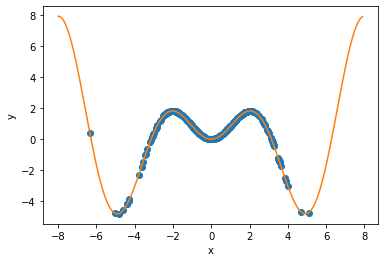

In [16]:
def get_1d_data_with_normal_distrib(funct, mu, sigma, n_samples, noise):
    """
    Generate noisy 1D data with normal distribution from given function
    and noise standard deviation.
    """
    np.random.seed(59)
    X_train = np.random.normal(mu, sigma, n_samples)
    X_test = np.arange(mu-4*sigma, mu+4*sigma, sigma/20.)
    y_train, y_mesh, y_test = funct(X_train), funct(X_test), funct(X_test)
    y_train += np.random.normal(0, noise, y_train.shape[0])
    y_test += np.random.normal(0, noise, y_test.shape[0])
    return X_train.reshape(-1, 1), y_train, X_test.reshape(-1, 1), y_test, y_mesh


mu = 0
sigma = 2
n_samples = 300
noise = 0.
X_train, y_train, X_test, y_test, y_mesh = get_1d_data_with_normal_distrib(
    x_sinx, mu, sigma, n_samples, noise
)

plt.xlabel("x")
plt.ylabel("y")
plt.scatter(X_train, y_train, color="C0")
_ = plt.plot(X_test, y_test, color="C1")


num_quand:  0.9059999999999999    quantile value: 0.025147691044690834
0.025147691044690834 0.025147691044690834
0.68125
q mapie  [0.906]
quantile mapie  [0.02514769 0.02514769]
0.68125


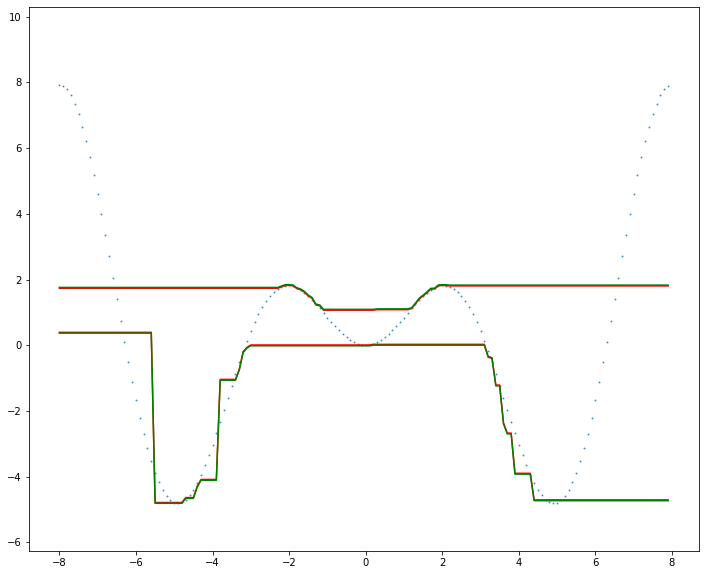

In [17]:
symmetry = True
alpha = 0.1


y_preds, y_preds_low, y_preds_low_cqr, y_preds_high, y_preds_high_cqr = conformed_quantile_prediction(
    X_train, y_train,  X_test, y_test, alpha, regression_method="GradientBoosting", CV=False, symmetry=symmetry)

print(regression_coverage_score(
    y_test, y_preds_low_cqr, y_preds_high_cqr
))

mapie_reg = MapieQuantileRegressor(
    GradientBoostingRegressor(loss="quantile"),
    cv="simple",
    alpha=alpha
)

mapie_reg.fit(X_train, y_train)
y_pred, y_pis = mapie_reg.predict(X_test, symmetry=symmetry)

print(regression_coverage_score(
    y_test, y_pis[:, 0, 0], y_pis[:, 1, 0]
))

fig, axs = plt.subplots(1, 1, figsize=(12, 10))
plot_results(axs, X_test, y_test, y_preds_low, y_preds_high,
             y_preds_low_cqr, y_preds_high_cqr)
